In [27]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import time

In [28]:
pruning_amounts = []
accuracies = []
comp_time = []
model_size = []
with open('alexnet_m4pro_cpu.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        pruning_amounts.append(float(row[0].replace('%', '')))
        accuracies.append(float(row[1].replace('%', '')))
        comp_time.append(float(row[2]))
        model_size.append(float(row[3]))


In [29]:
print(f"len accuracies: {len(accuracies)}, len comp_time: {len(comp_time)}, len model_size: {len(model_size)}")

len accuracies: 120, len comp_time: 120, len model_size: 120


In [30]:
def get_accuracy_reward(accuracy_new,  accuracy_min):
    if accuracy_new > (accuracy_min - 10**-3) and accuracy_new < (accuracy_min + 10**-3):
        return 500.0
    elif accuracy_new > (accuracy_min + 10**-3):
        return (accuracy_new - accuracy_min)*200
    else:
        return (accuracy_min - accuracy_new)*-1000.0

def get_model_size_reward(model_size_new,  model_size_mean):
    delta_model_size = model_size_new - model_size_mean
    if delta_model_size < 0:
        return -100*delta_model_size
    else:
        return 2000*delta_model_size

def get_comp_time_reward(comp_time_new,  comp_time_mean):
    delta_comp_time = comp_time_new - comp_time_mean
    return 100*delta_comp_time if delta_comp_time < 0 else 300 * delta_comp_time

def reward_func(accuracy,  model_size,  comp_time,  accuracy_min,  model_size_min,  comp_time_min,  x=0.0,  y=0.0,  z=0.0):
    accuracy_reward = get_accuracy_reward(accuracy,  accuracy_min)
    model_size_reward = get_model_size_reward(model_size,  model_size_min)
    comp_time_reward = get_comp_time_reward(comp_time,  comp_time_min)
    # print(accuracy_reward,  model_size_reward,  comp_time_reward)
    return (x*accuracy_reward) + (y*model_size_reward) + (z*comp_time_reward)

In [31]:
old_model_size,  old_comp_time = [model_size[0]], [comp_time[0]]
ACC_MIN = 49
#HYPERPARAMS
random_values = np.random.rand(3)
random_values /= random_values.sum()
ACCURACY_IMP = random_values[0]
MODEL_SIZE_IMP = random_values[1]
COMP_TIME_IMP = random_values[2]

if np.floor(np.ceil(ACCURACY_IMP + MODEL_SIZE_IMP + COMP_TIME_IMP)) != 1.0:
    print("Sum of hyperparameters = ",  ACCURACY_IMP + MODEL_SIZE_IMP + COMP_TIME_IMP)
    raise ValueError ("Hyperparameters are not correct")

print("Sum of hyperparameters = ",  ACCURACY_IMP + MODEL_SIZE_IMP + COMP_TIME_IMP)
    
print("Original Accuracy",  accuracies[0])

print(f"Hyperparameters: ACCURACY_IMP: {ACCURACY_IMP}, MODEL_SIZE_IMP: {MODEL_SIZE_IMP}, COMP_TIME_IMP: {COMP_TIME_IMP}")

rewards = []

for i in range(0,  len(accuracies)):
    reward = reward_func(accuracies[i],  model_size[i],  comp_time[i],  ACC_MIN,  
                         float(np.mean(old_model_size)),  float(np.mean(old_comp_time)),  ACCURACY_IMP,  MODEL_SIZE_IMP,  COMP_TIME_IMP)
    # print(f"Pruning amount: {pruning_amounts[i]},  Reward: {reward}")
    rewards.append(reward)
    old_model_size.append(model_size[i])
    old_comp_time.append(comp_time[i])

Sum of hyperparameters =  1.0
Original Accuracy 54.3055555555556
Hyperparameters: ACCURACY_IMP: 0.3985011227259952, MODEL_SIZE_IMP: 0.42851182467848553, COMP_TIME_IMP: 0.1729870525955193


In [32]:
max(rewards)

np.float64(1089.1257220125062)

In [33]:
index_max = np.argmax(rewards)
print(f"Max reward: {rewards[index_max]},  Pruning amount: {pruning_amounts[index_max]}, accuracy: {accuracies[index_max]},  comp_time: {comp_time[index_max]},  model_size: {model_size[index_max]}")

Max reward: 1089.1257220125062,  Pruning amount: 5.0, accuracy: 60.3055555555556,  comp_time: 0.990413427352905,  model_size: 225.98486328125


In [34]:
def normalize(lst: list) -> list:
    min_val = min(lst)
    max_val = max(lst)
    return ([(x - min_val) / (max_val - min_val) if max_val != min_val else 0 for x in lst])

In [35]:
normalized_rewards = normalize(rewards)

In [36]:
sum(comp_time)/len(comp_time)

0.8171879748503367

In [37]:
sigma = 1e-5
smoothed_rewards = gaussian_filter1d(rewards, sigma=sigma)

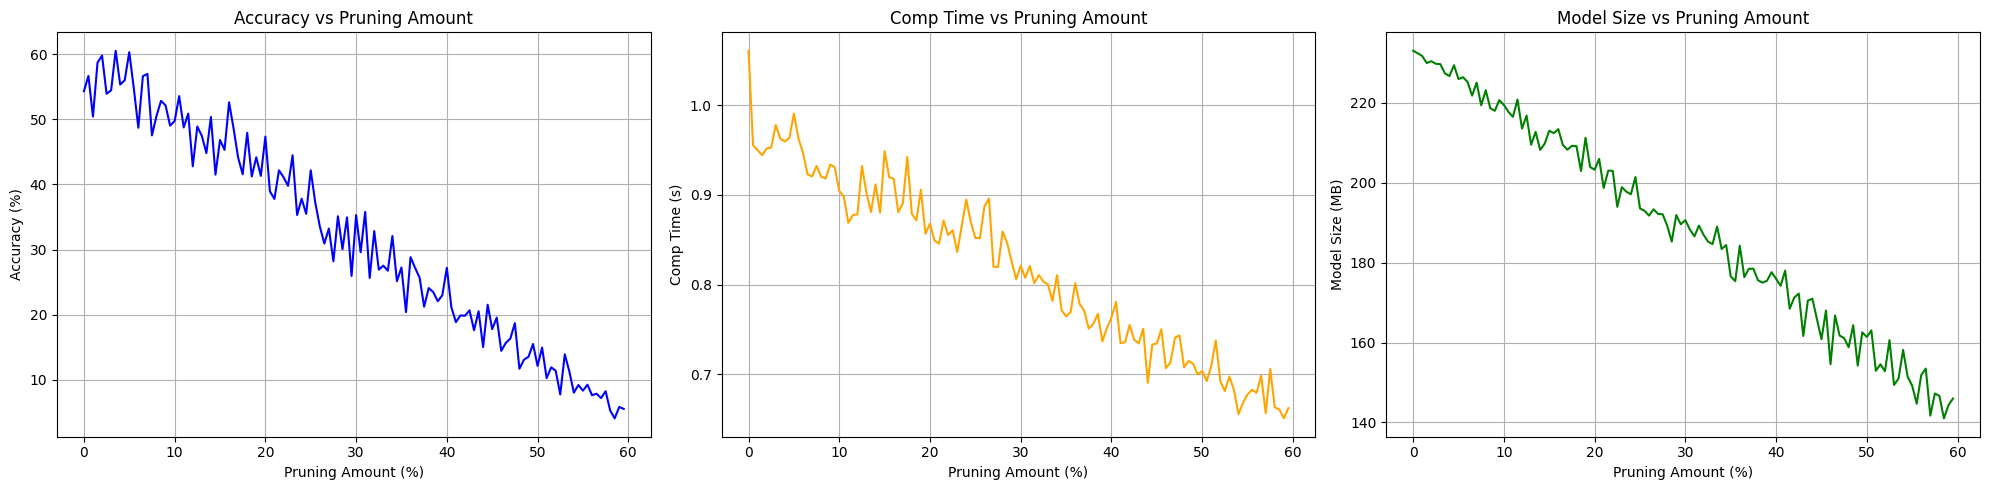

In [38]:
#plot accuracy, comp_time, model_size
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(pruning_amounts, accuracies,  label='Accuracy',  color='blue')
plt.xlabel('Pruning Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Pruning Amount')
plt.grid()
plt.subplot(132)
plt.plot(pruning_amounts, comp_time,  label='Comp Time',  color='orange')
plt.xlabel('Pruning Amount (%)')
plt.ylabel('Comp Time (s)')
plt.title('Comp Time vs Pruning Amount')
plt.grid()
plt.subplot(133)
plt.plot(pruning_amounts, model_size,  label='Model Size',  color='green')
plt.xlabel('Pruning Amount (%)')
plt.ylabel('Model Size (MB)')
plt.grid()
plt.title('Model Size vs Pruning Amount')
plt.tight_layout()
plt.show()

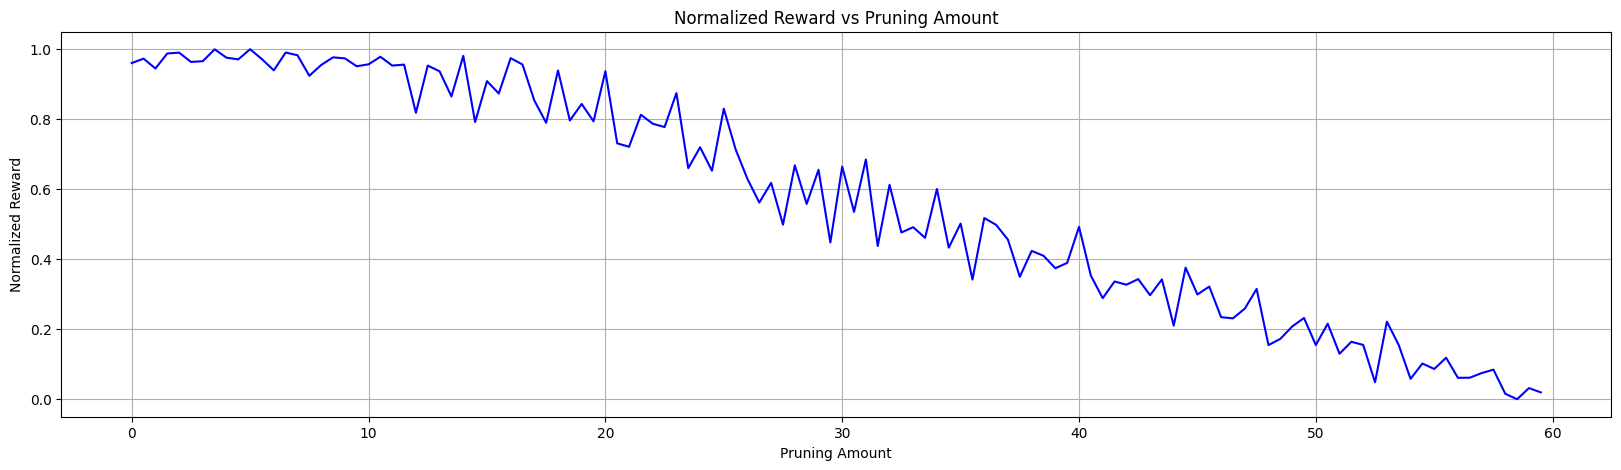

In [39]:
import matplotlib.pyplot as plt
plt.plot(pruning_amounts, normalize(smoothed_rewards),  label='Reward',  color='blue')
# plt.plot(pruning_amounts, normalize(accuracies),  label='Accuracy',  color='orange')
# plt.plot(pruning_amounts, normalize(model_size),  label='Model Size',  color='green')
# plt.plot(pruning_amounts, normalize(comp_time),  label='Comp Time',  color='red')
plt.xlabel('Pruning Amount')
plt.ylabel('Normalized Reward')
plt.title('Normalized Reward vs Pruning Amount')
plt.grid()
figsize = plt.gcf()
figsize.set_size_inches(20, 5)
plt.show()

In [40]:
def first_order_grad(rewards, pruning_amounts):
    sigma = 2  
    # smoothed_rewards = normalize(gaussian_filter1d(rewards, sigma=sigma))
    smoothed_rewards = rewards

    # Compute numerical gradient
    gradients = np.gradient(smoothed_rewards, pruning_amounts)

    # Gradient ascent parameters
    num_iterations = 100
    learning_rate = 0.1  # Initial step size
    momentum = 0.9       # Momentum factor
    num_restarts = 100    # Random restarts to avoid local maxima
    best_pruning_amount = None
    best_reward = -np.inf
    pruning_amounts = np.array(pruning_amounts)
    pruning_path = []

    start_time = time.time()
    for _ in range(num_restarts):
        # Start from a random pruning amount
        pruning_amount = np.random.uniform(min(pruning_amounts), max(pruning_amounts))
        velocity = 0  # Initialize momentum

        for _ in range(num_iterations):
            # Get the current gradient
            grad_index = np.abs(pruning_amounts - pruning_amount).argmin()
            grad = gradients[grad_index]
            
            # Apply momentum update
            velocity = momentum * velocity + learning_rate * grad
            pruning_amount += velocity  

            # Keep within bounds
            pruning_amount = np.clip(pruning_amount, min(pruning_amounts), max(pruning_amounts))

            # Decay learning rate over time for fine-tuning
            learning_rate *= 0.99  

        # Evaluate final reward
        final_index = np.abs(pruning_amounts - pruning_amount).argmin()
        final_reward = smoothed_rewards[final_index]
        pruning_path.append(pruning_amount)

        # Track the best solution found
        if final_reward > best_reward:
            best_reward = final_reward
            best_pruning_amount = pruning_amount

    print(f"Time Taken: {time.time()-start_time} seconds")
    # Print optimal results
    print(f"Optimal pruning amount: {best_pruning_amount:.4f}")
    print(f"Maximum reward: {best_reward:.4f}")


    # Plot results
    
    plt.plot(pruning_amounts, smoothed_rewards, label="Smoothed Reward", color="blue")
    plt.scatter(pruning_path, np.interp(pruning_path, pruning_amounts, smoothed_rewards), 
            color="red", s=1, label="Gradient Ascent Steps")
    plt.axvline(best_pruning_amount, color="red", linestyle="--", label="Optimal Pruning Amount")
    plt.xlabel("Pruning Amount")
    plt.ylabel("Smoothed Reward")
    plt.title("Finding Global Max with Randomized Gradient Ascent")
    plt.legend()
    plt.grid()
    figsize = plt.gcf()
    figsize.set_size_inches(20, 10)
    plt.show()

In [41]:
def second_order_grad(rewards, pruning_amounts):
    sigma = 2  
    # smoothed_rewards = normalize(gaussian_filter1d(rewards, sigma=sigma))
    smoothed_rewards = rewards

    # Compute numerical gradient and second derivative (curvature)
    gradients = np.gradient(smoothed_rewards, pruning_amounts)
    curvatures = np.gradient(gradients, pruning_amounts)

    # Gradient ascent parameters
    num_iterations = 10
    initial_learning_rate = 0.1  # Initial step size
    momentum = 0.9               # Momentum factor
    num_restarts = 10            # Random restarts to avoid local maxima
    best_pruning_amount = None
    best_reward = -np.inf
    pruning_amounts = np.array(pruning_amounts)

    start_time = time.time()
    pruning_path = []

    for _ in range(num_restarts):
        # Start from a random pruning amount
        pruning_amount = np.random.uniform(min(pruning_amounts), max(pruning_amounts))
        velocity = 0  # Initialize momentum
        learning_rate = initial_learning_rate  # Reset learning rate

        for _ in range(num_iterations):
            # Get the current gradient and curvature
            grad_index = np.abs(pruning_amounts - pruning_amount).argmin()
            grad = gradients[grad_index]
            curvature = curvatures[grad_index]

            # Adaptive learning rate using second derivative
            adaptive_lr = learning_rate / (1 + np.abs(curvature))

            # Apply momentum update
            velocity = momentum * velocity + adaptive_lr * grad
            pruning_amount += velocity  

            # Keep within bounds
            pruning_amount = np.clip(pruning_amount, min(pruning_amounts), max(pruning_amounts))

            # Decay learning rate over time for fine-tuning
            learning_rate *= 0.99  
            pruning_path.append(pruning_amount)

        # Evaluate final reward
        final_index = np.abs(pruning_amounts - pruning_amount).argmin()
        final_reward = smoothed_rewards[final_index]

        # Track the best solution found
        if final_reward > best_reward:
            best_reward = final_reward
            best_pruning_amount = pruning_amount

    print(f"Time Taken: {time.time()-start_time} seconds")
    # Print optimal results
    print(f"Optimal pruning amount: {best_pruning_amount:.4f}")
    print(f"Maximum reward: {best_reward:.4f}")

    # Plot results
    # plt.plot(pruning_amounts, smoothed_rewards, label="Smoothed Reward", color="blue")
    # plt.scatter(pruning_path, np.interp(pruning_path, pruning_amounts, smoothed_rewards), 
    #         color="red", s=1, label="Gradient Ascent Steps")
    # plt.axvline(best_pruning_amount, color="red", linestyle="--", label="Optimal Pruning Amount")
    # plt.xlabel("Pruning Amount")
    # plt.ylabel("Smoothed Reward")
    # plt.title("Finding Global Max with Second-Order Gradient Ascent")
    # plt.legend()
    # plt.grid()
    # figsize = plt.gcf()
    # figsize.set_size_inches(20, 10)
    # plt.show()
    return pruning_amount, smoothed_rewards, best_pruning_amount, best_reward

In [42]:
def adam_grad(rewards, pruning_amounts):
    sigma = 2  
    smoothed_rewards = rewards
    # smoothed_rewards = normalize(gaussian_filter1d(rewards, sigma=sigma))

    # Compute numerical gradient
    gradients = np.gradient(smoothed_rewards, pruning_amounts)

    # Adam parameters
    num_iterations = 10
    initial_learning_rate = 0.1  # Initial step size
    beta1, beta2 = 0.9, 0.999  # Adam hyperparameters
    epsilon = 1e-8  # To prevent division by zero
    num_restarts = 10  # Random restarts to avoid local maxima
    best_pruning_amount = None
    best_reward = -np.inf
    pruning_amounts = np.array(pruning_amounts)

    start_time = time.time()
    pruning_path = []

    for _ in range(num_restarts):
        pruning_amount = np.random.uniform(min(pruning_amounts), max(pruning_amounts))
        m, v = 0, 0  # First and second moments
        learning_rate = initial_learning_rate

        for t in range(1, num_iterations + 1):
            grad_index = np.abs(pruning_amounts - pruning_amount).argmin()
            grad = gradients[grad_index]

            # Adam update
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad ** 2)
            m_hat = m / (1 - beta1 ** t)  # Bias correction
            v_hat = v / (1 - beta2 ** t)  # Bias correction

            pruning_amount += (learning_rate * m_hat) / (np.sqrt(v_hat) + epsilon)
            pruning_amount = np.clip(pruning_amount, min(pruning_amounts), max(pruning_amounts))

            pruning_path.append(pruning_amount)

        # Evaluate final reward
        final_index = np.abs(pruning_amounts - pruning_amount).argmin()
        final_reward = smoothed_rewards[final_index]

        if final_reward > best_reward:
            best_reward = final_reward
            best_pruning_amount = pruning_amount

    print(f"Time Taken: {time.time()-start_time} seconds")
    print(f"Optimal pruning amount: {best_pruning_amount:.4f}")
    print(f"Maximum reward: {best_reward:.4f}")

    # Plot results
    # plt.plot(pruning_amounts, smoothed_rewards, label="Smoothed Reward", color="blue")
    # plt.scatter(pruning_path, np.interp(pruning_path, pruning_amounts, smoothed_rewards), 
    #             color="red", s=1, label="Gradient Ascent Steps")
    # plt.axvline(best_pruning_amount, color="red", linestyle="--", label="Optimal Pruning Amount")
    # plt.xlabel("Pruning Amount")
    # plt.ylabel("Smoothed Reward")
    # plt.title("Finding Global Max with Adam Gradient Ascent")
    # plt.legend()
    # plt.grid()
    # figsize = plt.gcf()
    # figsize.set_size_inches(20, 10)
    # plt.show()
    
    return pruning_amount, smoothed_rewards, best_pruning_amount, best_reward

In [43]:
def simulated_annealing(rewards, pruning_amounts):
    sigma = 2  
    smoothed_rewards = rewards
    # smoothed_rewards = normalize(gaussian_filter1d(rewards, sigma=sigma))

    # Compute numerical gradient
    gradients = np.gradient(smoothed_rewards, pruning_amounts)

    # Simulated Annealing parameters
    num_iterations = 10
    initial_temperature = 1.0
    cooling_rate = 0.99
    num_restarts = 10
    best_pruning_amount = None
    best_reward = -np.inf
    pruning_amounts = np.array(pruning_amounts)

    start_time = time.time()
    pruning_path = []

    for _ in range(num_restarts):
        pruning_amount = np.random.uniform(min(pruning_amounts), max(pruning_amounts))
        temperature = initial_temperature

        for _ in range(num_iterations):
            grad_index = np.abs(pruning_amounts - pruning_amount).argmin()
            grad = gradients[grad_index]

            new_pruning = pruning_amount + 0.1 * grad
            new_pruning = np.clip(new_pruning, min(pruning_amounts), max(pruning_amounts))

            # Compute probability of accepting the new state
            delta_reward = smoothed_rewards[np.abs(pruning_amounts - new_pruning).argmin()] - \
                           smoothed_rewards[grad_index]
            if delta_reward > 0 or np.random.rand() < np.exp(delta_reward / temperature):
                pruning_amount = new_pruning

            temperature *= cooling_rate  # Reduce temperature
            pruning_path.append(pruning_amount)

        # Evaluate final reward
        final_index = np.abs(pruning_amounts - pruning_amount).argmin()
        final_reward = smoothed_rewards[final_index]

        if final_reward > best_reward:
            best_reward = final_reward
            best_pruning_amount = pruning_amount

    print(f"Time Taken: {time.time()-start_time} seconds")
    print(f"Optimal pruning amount: {best_pruning_amount:.4f}")
    print(f"Maximum reward: {best_reward:.4f}")

    # Plot results
    # plt.plot(pruning_amounts, smoothed_rewards, label="Smoothed Reward", color="blue")
    # plt.scatter(pruning_path, np.interp(pruning_path, pruning_amounts, smoothed_rewards), 
    #             color="red", s=1, label="Gradient Ascent Steps")
    # plt.axvline(best_pruning_amount, color="red", linestyle="--", label="Optimal Pruning Amount")
    # plt.xlabel("Pruning Amount")
    # plt.ylabel("Smoothed Reward")
    # plt.title("Finding Global Max with Simulated Annealing")
    # plt.legend()
    # plt.grid()
    # figsize = plt.gcf()
    # figsize.set_size_inches(20, 10)
    # plt.show()
    
    return pruning_amount, smoothed_rewards, best_pruning_amount, best_reward

In [44]:
def add_pruning_data(pruning_amounts, accuracy, comp_time, model_size, step=0.1, window_size=2, poly_order=1, noise=1.0):
    df = pd.DataFrame({'pruning': pruning_amounts, 'accuracy': accuracy, 'comp_time': comp_time, 'model_size': model_size})
    
    new_pruning_amounts = np.arange(0, np.max(pruning_amounts) + step, step)
    df_interp = df.set_index('pruning').reindex(new_pruning_amounts).interpolate(method='linear')
    
    # Apply Savitzky-Golay filter for smoothing
    def smooth_series(series):
        return savgol_filter(series, window_size, poly_order, mode='nearest') if len(series) > window_size else series
    
    df_interp['accuracy_smooth'] = smooth_series(df_interp['accuracy'].values)
    df_interp['model_size_smooth'] = smooth_series(df_interp['model_size'].values)
    df_interp['comp_time_smooth'] = smooth_series(df_interp['comp_time'].values)
    
    # Add noise if specified
    if noise != 0.0:
        new_acc = smooth_series(df_interp['accuracy_smooth'].values) + np.random.logistic(scale=noise, size=len(df_interp))
        new_comp = smooth_series(df_interp['comp_time_smooth'].values) + np.random.logistic(scale=noise, size=len(df_interp))
        new_size = smooth_series(df_interp['model_size_smooth'].values) + np.random.logistic(scale=noise, size=len(df_interp))
        return new_pruning_amounts, new_acc, new_comp, new_size
    else:
        return new_pruning_amounts, df_interp['accuracy_smooth'].values, df_interp['comp_time_smooth'].values, df_interp['model_size_smooth'].values


In [45]:
new_pruning, new_acc, new_comp, new_size = add_pruning_data(
    np.array(pruning_amounts), \
    np.array(accuracies), 
    np.array(comp_time), 
    np.array(model_size), 
    step=0.1,
    window_size=5,
    poly_order=2,
    noise=0.0
)
print(f"pruning {len(new_pruning)}, accuracy {len(new_acc)}, comp_time {len(new_comp)}, model_size {len(new_size)}")

pruning 596, accuracy 596, comp_time 596, model_size 596


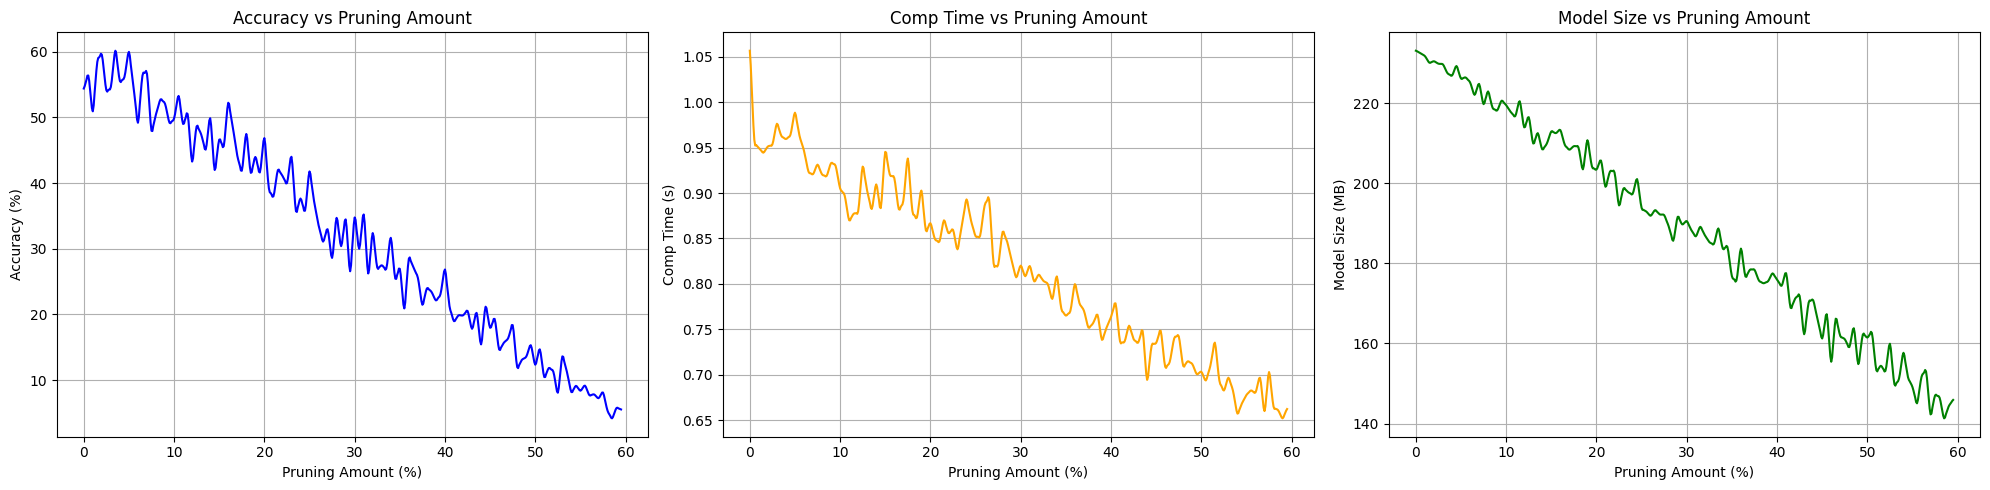

In [46]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(new_pruning, new_acc,  label='Accuracy',  color='blue')
plt.xlabel('Pruning Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Pruning Amount')
plt.grid()
plt.subplot(132)
plt.plot(new_pruning, new_comp,  label='Comp Time',  color='orange')
plt.xlabel('Pruning Amount (%)')
plt.ylabel('Comp Time (s)')
plt.title('Comp Time vs Pruning Amount')
plt.grid()
plt.subplot(133)
plt.plot(new_pruning, new_size,  label='Model Size',  color='green')
plt.xlabel('Pruning Amount (%)')
plt.ylabel('Model Size (MB)')
plt.grid()
plt.title('Model Size vs Pruning Amount')
plt.tight_layout()
plt.show()

In [47]:
new_rewards = []
old_model_size, old_comp_time = new_size[0], new_comp[0]

for i in range(len(new_pruning)):
    reward = reward_func(
        accuracy=abs(new_acc[i]), model_size=new_size[i], comp_time=new_comp[i], accuracy_min=ACC_MIN,
        model_size_min=old_model_size, comp_time_min=old_comp_time, 
        x=ACCURACY_IMP, y=COMP_TIME_IMP, z=MODEL_SIZE_IMP
    )
    new_rewards.append(float((reward)))

In [48]:
def save_to_csv(pruning_amounts, accuracies, comp_time, model_size, new_rewards, norm_rewards):
    with open('pruning_results_extra_steps.csv', 'w') as file:
        file.write("Pruning amount, Accuracy, Comp time, Model size, Reward, Norm Reward\n")
        for i in range(len(pruning_amounts)):
            data = f"{pruning_amounts[i]}, {accuracies[i]}, {comp_time[i]}, {model_size[i]}, {rewards[i]}, {norm_rewards[i]}\n"
            file.write(data)

In [49]:
#print max reward
index_max = np.argmax(new_rewards) 
print(f"Max reward: {new_rewards[index_max]},  Pruning amount: {new_pruning[index_max]}")
print(f"Accuracy at max reward: {new_acc[index_max]},  Comp time: {new_comp[index_max]},  Model size: {new_size[index_max]}")


Max reward: 991.2336112218441,  Pruning amount: 5.0
Accuracy at max reward: 59.96746031746033,  Comp time: 0.9885484899793345,  Model size: 226.11950073242176


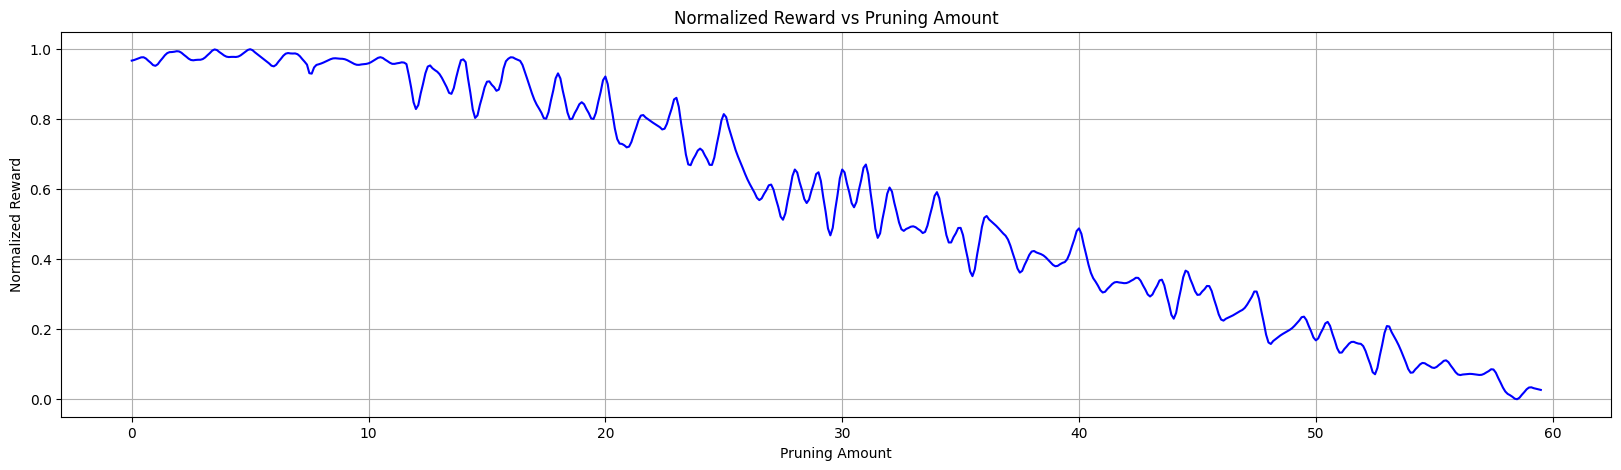

In [50]:
#plot norm_rewards
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(new_pruning, normalize(new_rewards), label='Reward', color='blue')
plt.xlabel('Pruning Amount')
plt.ylabel('Normalized Reward')
plt.title('Normalized Reward vs Pruning Amount')
plt.grid()
plt.show()

In [51]:
def find_best(second_order_res, adam_res, simulated_annealing_res):
    # Extract rewards
    rewards = {
    "Second Order Gradient Ascent": second_order_res,
    "Adam": adam_res,
    "Simulated Annealing": simulated_annealing_res
    }

    # Find the method with the highest reward
    best_method = max(rewards, key=rewards.get)
    best_reward = rewards[best_method]

    # Print results
    for method, reward in rewards.items():
        print(f"Highest reward with {method}: {reward}")

    print(f"\nThe highest reward is {best_reward}, achieved with {best_method}.")
    
    #second best
    del rewards[best_method]
    second_best_method = max(rewards, key=rewards.get)
    second_best_reward = rewards[second_best_method]
    print(f"The second highest reward is {second_best_reward}, achieved with {second_best_method}.")
    
    #third best
    del rewards[second_best_method]
    third_best_method = max(rewards, key=rewards.get)
    third_best_reward = rewards[third_best_method]
    print(f"The third highest reward is {third_best_reward}, achieved with {third_best_method}.")

Time Taken: 0.0037670135498046875 seconds
Optimal pruning amount: 6.5769
Maximum reward: 0.9890
Time Taken: 0.0037512779235839844 seconds
Optimal pruning amount: 5.0306
Maximum reward: 1.0000
Time Taken: 0.003014087677001953 seconds
Optimal pruning amount: 5.0963
Maximum reward: 0.9973


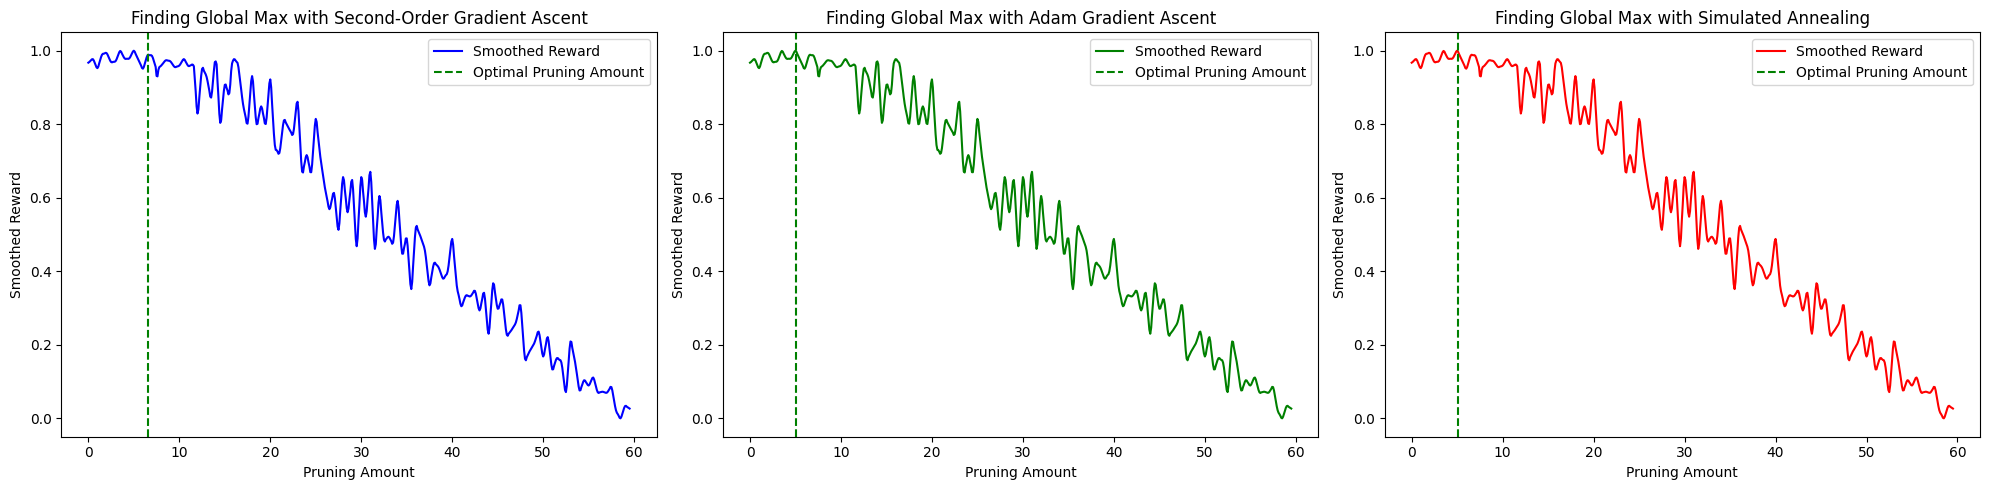

Highest reward with Second Order Gradient Ascent: 0.9890486498283682
Highest reward with Adam: 1.0
Highest reward with Simulated Annealing: 0.9973179045314451

The highest reward is 1.0, achieved with Adam.
The second highest reward is 0.9973179045314451, achieved with Simulated Annealing.
The third highest reward is 0.9890486498283682, achieved with Second Order Gradient Ascent.

HYPERPARAMS: ACC IMP: 0.3985011227259952, COMP_TIME_IMP: 0.1729870525955193, MODEL_SIZE_IMP: 0.42851182467848553


In [52]:
second_order_res = second_order_grad(normalize(new_rewards), new_pruning)
adam_res = adam_grad(normalize(new_rewards), new_pruning)
simulated_annealing_res = simulated_annealing(normalize(new_rewards), new_pruning)


plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(new_pruning, normalize(new_rewards), label='Smoothed Reward', color='blue')
plt.axvline(second_order_res[2], color="green", linestyle="--", label="Optimal Pruning Amount")
plt.xlabel("Pruning Amount")
plt.ylabel("Smoothed Reward")
plt.title("Finding Global Max with Second-Order Gradient Ascent")
plt.legend()

plt.subplot(132)
plt.plot(new_pruning, normalize(new_rewards), label='Smoothed Reward', color='green')
plt.axvline(adam_res[2], color="green", linestyle="--", label="Optimal Pruning Amount")
plt.xlabel("Pruning Amount")
plt.ylabel("Smoothed Reward")
plt.title("Finding Global Max with Adam Gradient Ascent")
plt.legend()

plt.subplot(133)
plt.plot(new_pruning, normalize(new_rewards), label='Smoothed Reward', color='red')
plt.axvline(simulated_annealing_res[2], color="green", linestyle="--", label="Optimal Pruning Amount")
plt.xlabel("Pruning Amount")
plt.ylabel("Smoothed Reward")
plt.title("Finding Global Max with Simulated Annealing")
plt.legend()
plt.tight_layout()
plt.show()

find_best(
    second_order_res[3], 
    adam_res[3], 
    simulated_annealing_res[3]
)
print(f"\nHYPERPARAMS: ACC IMP: {ACCURACY_IMP}, COMP_TIME_IMP: {COMP_TIME_IMP}, MODEL_SIZE_IMP: {MODEL_SIZE_IMP}")
